In [1]:
import data_functions as dat
import importlib
import itertools
import math
import matplotlib.pyplot as plt
#from metric_functions import *
import multiprocessing as mp
import numpy as np
import os, os.path
import pandas as pd
import pyDOE2 as pyd
import scipy.optimize as sco
import setup_analysis as sa
import time
import ri_water_model as rm
importlib.reload(dat)
importlib.reload(sa)


<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2022/crdm_project/python/setup_analysis.py'>

###  First, let's read in key data sets and print off some information for our analysis.

In [2]:
# read in input data
df_model_data = pd.read_csv(sa.fp_csv_baseline_trajectory_model_input_data)
df_climate_deltas_annual = pd.read_csv(sa.fp_csv_climate_deltas_annual)

# show a record of info
print(f"Analysis Information from setup_analysis.py\n\n\tanalysis_name:\t{sa.analysis_name}\n\tn_lhs:\t{sa.n_lhs}")


Analysis Information from setup_analysis.py

	analysis_name:	crdm_project_2021091
	n_lhs:	10


###  Next, let's load the strategy table

In [3]:
# get the strategies and attribute table from the excel file
df_attr_strategy, df_strategies = dat.get_strategy_table(sa.fp_xlsx_strategy_inputs, field_strategy_id = sa.field_key_strategy)


###  Add the LHS samples

In [4]:

# setup ranges for lhs
dict_ranges = {
    "flow_m3s": [
        0.95*min(df_climate_deltas_annual["delta_q_2055_annual"]), 
        1.05*max(df_climate_deltas_annual["delta_q_2055_annual"])
    ],
    "precipitation_mm": [
        0.95*min(df_climate_deltas_annual["delta_p_2055_annual"]), 
        1.05*max(df_climate_deltas_annual["delta_p_2055_annual"])
    ],
    "population": [0.8, 1.3],
    "demand_municipal_m3p": [0.8, 1.2],
    "demand_agricultural_m3km2": [0.9, 1.1],
    "area_ag_km2": [0.8, 1.5]
}
# set future 0 values - different because we'll apply deltas differently
dict_f0_vals = {
    "flow_m3s": 0,
    "precipitation_mm": 0,
    "population": 1,
    "demand_municipal_m3p": 1,
    "demand_agricultural_m3km2": 1,
    "area_ag_km2": 1
}
# build lhs samples
df_lhs = dat.generate_lhs_samples(sa.n_lhs, dict_ranges, dict_f0_vals, sa.field_key_future)

###  Apply the climate deltas

In [5]:

##  Climate Deltas

t0 = time.time()
dict_climate_factor_delta_field_map =  {
    "flow_m3s": "flow_m3s",
    "precipitation_mm": "precipitation_mm"
}
df_climate_deltas_by_future = dat.get_climate_factor_deltas(
    df_model_data,
    df_lhs,
    dict_climate_factor_delta_field_map,
    sa.range_delta_base, 
    sa.range_delta_fut, 
    max(sa.model_historical_years),
    field_future_id = sa.field_key_future
)
t1 = time.time()
t_del = np.round(t1 - t0, 2)
print(f"Time to generate {sa.n_lhs} climate deltas: {t_del} seconds")



Time to generate 10 climate deltas: 0.23 seconds


###  Let's add the other uncertainty deltas (treated differently)

In [6]:
# get time period information
t0 = max(df_model_data[df_model_data["year"] == min(sa.model_projection_years) - 1]["time_period"])
t1 = max(df_model_data["time_period"])

# run the function
df_other_deltas_by_future = dat.get_linear_delta_trajectories_by_future(
    df_model_data,
    df_lhs[[x for x in df_lhs.columns if x not in dict_climate_factor_delta_field_map.keys()]],
    t0,
    t1,
    field_future_id = sa.field_key_future
)
# merge back in some data
df_other_deltas_by_future = pd.merge(df_other_deltas_by_future, df_model_data[["time_period", "year", "month"]])



###  Build a unified futures database

In [7]:
df_futures = pd.merge(df_climate_deltas_by_future, df_other_deltas_by_future)
# some column sorting
fields_ind = ["future_id", "time_period", "year", "month"]
fields_dat = sorted([x for x in df_futures.columns if x not in fields_ind])
df_futures = df_futures[fields_ind + fields_dat]

###  Create a primary key, which we can use for an experimental design

In [8]:
def build_primary_attribute(
    df_fut: pd.DataFrame,
    df_strat: pd.DataFrame,
    field_key_future: str = "future_id",
    field_key_primary: str = "primary_id",
    field_key_strategy: str = "strategy_id"
) -> pd.DataFrame:
    # create a primary key
    fields_index = [field_key_strategy, field_key_future]
    field_primary_key = field_key_primary
    df_attribute_primary = pd.DataFrame(
        list(itertools.product(
            list(df_strat[field_key_strategy]), 
            list(df_fut[field_key_future])
        )), 
        columns = fields_index
    )
    df_attribute_primary[field_key_primary] = range(len(df_attribute_primary))
    df_attribute_primary = df_attribute_primary[[field_key_primary] + fields_index]
    
    return df_attribute_primary

df_attribute_primary = build_primary_attribute(
    df_lhs, 
    df_attr_strategy, 
    sa.field_key_future, 
    sa.field_key_primary, 
    sa.field_key_strategy
)



###  Run the model under default conditions

In [9]:
df_out = rm.ri_water_resources_model(df_model_data)

RI model done in 1.19 seconds.


###  Define a function to run the model for a single scenario

In [10]:
# function here
def get_model_data_from_primary_key(
    id_primary: int,
    df_attribute_primary: pd.DataFrame,
    df_futures: pd.DataFrame,
    df_strategies: pd.DataFrame,
    field_primary_key: str = "primary_id",
    field_future: str = "future_id", 
    field_strategy: str = "strategy_id"
):
    row_scenario = df_attribute_primary[df_attribute_primary[field_primary_key] == id_primary]
    # get ids
    id_future = int(row_scenario[field_future])
    id_primary = int(row_scenario[field_primary_key])
    id_strategy = int(row_scenario[field_strategy])

    # get input data
    df_future = df_futures[df_futures[field_future] == id_future].copy()
    df_future.drop([field_future], axis = 1, inplace = True)
    df_strategy = df_strategies[df_strategies[field_strategy] == id_strategy].copy()
    df_strategy.drop([field_strategy], axis = 1, inplace = True)
    df_input_data = pd.merge(df_future, df_strategy)
    
    return df_input_data


def run_model_by_primary_key(
    id_primary: int,
    df_attribute_primary: pd.DataFrame,
    df_futures: pd.DataFrame,
    df_strategies: pd.DataFrame,
    field_primary_key: str = "primary_id",
    field_future: str = "future_id", 
    field_strategy: str = "strategy_id"
):

    df_input_data = get_model_data_from_primary_key(
        id_primary,
        df_attribute_primary,
        df_futures,
        df_strategies,
        field_primary_key,
        field_future, 
        field_strategy
    )
    # model output
    df_out = rm.ri_water_resources_model(df_input_data)
    fields_ord = list(df_out.columns)
    df_out[field_primary_key] = id_primary
    df_out = df_out[[field_primary_key] + fields_ord]

    return df_out



###  Try running the model for a selected primary_id

In [11]:
id_primary = 10
df_run = run_model_by_primary_key(
    id_primary,
    df_attribute_primary,
    df_futures,
    df_strategies
)

RI model done in 1.13 seconds.


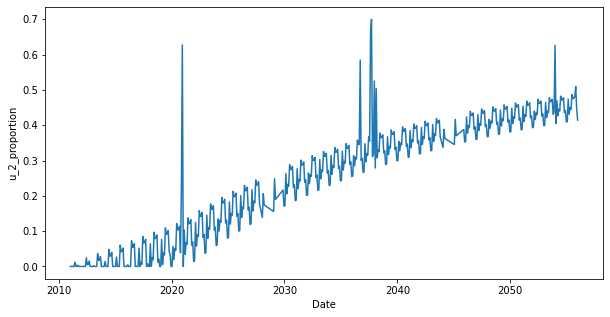

In [16]:
# 474
n = len(df_run)
flds_explore = [x for x in df_run.columns if (x not in ["year", "month"])]
flds_explore = ["u_2_proportion"]
for i in flds_explore:
    x = np.array(df_run["year"]) + (np.array(df_run["month"]) - 0.5)/12
    y = np.array(df_run[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()
    

###  Let's select some scenarios to run

In [12]:
all_primaries = list(df_attribute_primary[
    df_attribute_primary["strategy_id"].isin([0, 1])&
    df_attribute_primary["future_id"].isin([0, 481, 903])
]["primary_id"])


In [14]:

global get_mean_reservoir
def get_mean_reservoir(
    df_cur: pd.DataFrame,
    field_key_primary: str = "primary_id",
    field_metric: str = "mean_reservoir_storage_last_ten_years_m3",
    field_storage: str = "reservoir_storage_m3",
    field_year: str = "year",
    last_n_years: int = 10
) -> pd.DataFrame:

    y1 = max(df_cur[field_year])
    y0 = y1 - last_n_years + 1
    years_keep = range(y0, y1 + 1)

    mean_out = np.mean(df_cur[df_cur[field_year].isin(years_keep)][field_storage])
    df_metric = pd.DataFrame({field_key_primary: [int(df_cur[field_key_primary].loc[0])], field_metric: [mean_out]})

    return df_metric

global get_unacceptable_unmet_demand
def get_unacceptable_unmet_demand(
    df_cur: pd.DataFrame,
    field_key_primary: str = "primary_id",
    field_measure: str = "u_2_proportion",
    field_metric_exceed: str = "exceed_threshes",
    field_metric_prop: str = "proportion_unacceptable_unmet_demand",
    field_month: str = "month",
    field_year: str = "year",
    thresh_count: int = 6,
    thresh_demand: float = 0.2
) -> pd.DataFrame:
    
    vec_exceed_thresh_demand = [int(x > thresh_demand) for x in list(df_cur[field_measure])]
    
    field_pass_through = "exceed_thresh_demand"
    df_return = df_cur[[field_year, field_month, field_measure]].copy()
    df_return[field_pass_through] = vec_exceed_thresh_demand
    
    df_return = df_return.groupby([field_year]).agg({field_year: "first", field_pass_through: "sum"})
    df_return.reset_index(drop = True, inplace = True)
    
    vec_flag = [int(x >= thresh_count) for x in list(df_return[field_pass_through])]
    df_return[field_metric_exceed] = vec_flag
    
    metric_frac_vuln = np.sum(df_return[field_metric_exceed])/len(df_return)
    df_metric = pd.DataFrame({field_key_primary: [int(df_cur[field_key_primary].loc[0])], field_metric_prop: [metric_frac_vuln]})
    
    return df_return[[field_year, field_metric_exceed]], df_metric

In [15]:
###########################
#    SERIAL 'FOR' LOOP    #
###########################

# initialize output values
vec_out = []

# set timer baseline
t0_serial = time.time()

df_out = []
# simple loop over
for id_primary in enumerate(all_primaries):
    
    ind, id_primary = id_primary
    
    ##  raw model output
    df_cur = run_model_by_primary_key(
        id_primary,
        df_attribute_primary,
        df_futures,
        df_strategies
    )

    
    ########################################################
    #    INSERT RELEVANT POST-PROCESSING FUNCTIONS HERE    #
    ########################################################

    df_metric_1 = get_mean_reservoir(
        df_cur,
        sa.field_key_primary,
        "mean_reservoir_storage_last_ten_years_m3",
        "reservoir_storage_m3",
        "year",
        10
    )
    df_year_unacceptable, df_metric_2 = get_unacceptable_unmet_demand(
        df_cur,
        field_key_primary = sa.field_key_primary,
        field_measure = "u_2_proportion",
        field_metric_exceed = "exceed_threshes",
        field_metric_prop = "proportion_unacceptable_unmet_demand",
        field_month = "month",
        field_year = "year",
        thresh_count = 6,
        thresh_demand = 0.2
    )
    
    df_metrics_summary = pd.merge(df_metric_1, df_metric_2)
    
    if len(df_out) == 0:
        df_out = [df_metrics_summary for x in all_primaries]
    else:
        df_out[ind] = df_metrics_summary[df_out[0].columns]
    
df_out = pd.concat(df_out, axis = 0).reset_index(drop = True)

t1_serial = time.time()
t_elapse_serial = t1_serial - t0_serial

print("Serial run complete in %s seconds."%t_elapse_serial)



RI model done in 1.16 seconds.
RI model done in 1.21 seconds.
Serial run complete in 2.419968843460083 seconds.


In [19]:
df_1 = pd.merge(df_attribute_primary, df_out)
df_1 = pd.merge(df_lhs, df_1)
df_1

,future_id,area_ag_km2,demand_agricultural_m3km2,demand_municipal_m3p,flow_m3s,population,precipitation_mm,primary_id,strategy_id,mean_reservoir_storage_last_ten_years_m3,proportion_unacceptable_unmet_demand
0,0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1.278909e+08,0.377778
1,0,1.0,1.0,1.0,0.0,1.0,0.0,11,1,1.308107e+08,0.000000


In [18]:
###############################
#    ASYNCHRONOUS PARALLEL    #
###############################

t0_par_async = time.time()

#
# SOLUTION TO GET APPLY_ASYNC TO WORK WITH JUPYTER LAB: FUNCTION HAS TO BE PLACED IN MODULE AND IMPORTED: https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3
# https://towardsdatascience.com/asynchronous-parallel-programming-in-python-with-multiprocessing-a3fc882b4023
#


# initialize output vector/array (pre-allocate memory)
vec_df_out_ri = []

def get_result(result):
    
    global vec_df_out_ri
    vec_df_out_ri.append(result)
    
def get_result0(result):
    
    id_primary, df_ret = result
    
    global get_mean_reservoir
    global get_unacceptable_unmet_demand
    
    df_metric_1 = get_mean_reservoir(
        df_ret,
        "primary_id",
        "mean_reservoir_storage_last_ten_years_m3",
        "reservoir_storage_m3",
        "year",
        10
    )
    
    df_year_unacceptable, df_metric_2 = get_unacceptable_unmet_demand(
        df_ret,
        field_key_primary = "primary_id",
        field_measure = "u_2_proportion",
        field_metric_exceed = "exceed_threshes",
        field_metric_prop = "proportion_unacceptable_unmet_demand",
        field_month = "month",
        field_year = "year",
        thresh_count = 6,
        thresh_demand = 0.2
    )
    
    fields_ord = list(df_ret.columns)
    df_ret[field_key_primary] = id_primary
    df_ret = df_ret[[field_key_primary] + fields_ord]
    
    vec_df_out_ri.append(df_result)


    
# check to ensure current module is "__main__"; this is necessary in scripts that use multiprocessing. Without it, the processing framework will run the entirety of the original script in parallel
if __name__ == "__main__":
    
    global get_mean_reservoir
    global get_unacceptable_unmet_demand

    # start the MP pool for asynchronous parallelization
    pool = mp.Pool(int(mp.cpu_count()/2))

    # apply the function; note: if the function only takes one argument (e.g., f(x)), make sure the args is args = (x, ) - that extra comma is important
    for id_primary in all_primaries:
        # function here
        
        df_input_data = get_model_data_from_primary_key(
            id_primary,
            df_attribute_primary,
            df_futures,
            df_strategies,
            sa.field_key_primary,
            sa.field_key_future, 
            sa.field_key_strategy
        )


        pool.apply_async(
            # target function
            rm.ri_water_resources_model,
            # function arguments 
            args = (
                df_input_data,
                rm.md_dict_initial_states, 
                rm.md_dict_parameters, 
                rm.md_dict_default_levers,
                id_primary
            ),
            callback = get_result
        )

     
    pool.close()
    pool.join()
    t1_par_async = time.time()

    # 
    t_elapse_par_async = t1_par_async - t0_par_async

# print the reduction in time
print("Asynchronous parallelization across %s cores reduced computational time by %s%s."%(mp.cpu_count(), round(100*(1 - t_elapse_par_async/t_elapse_serial), 2), "%"))



Asynchronous parallelization across 12 cores reduced computational time by 4.87%.
